#### Deep Learning

##### Load Libraries and Clean Data

In [174]:
# data / visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nlp libraries
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords   # to get collection of stopwords
nltk.download('stopwords') # download stopwords
import pickle

# ml libraries
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import datasets, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History   # save model
from tensorflow.keras.models import load_model   # load saved model
from keras.metrics import Precision, Recall





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
######### Functions #########

# Regex Remove functions
# remove url
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

    # remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

# remove url, hashtag, at, stop words, punctuation
def removeFunc(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x = get_text_processing(x.lower())
    return x

# Max length of review
def get_max_length(x):
    review_length = []
    for review in x:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))



In [3]:
# load df1
df1 = pd.read_csv('data3/Twitter_Data.csv')
df1.head(1)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0


In [4]:
# load df2
df2 = pd.read_csv('data3/apple-twitter-sentiment-texts.csv')
# rename columns
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df2.head(1)

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0


In [7]:
# load df3
df3 = pd.read_csv('data3/finalSentimentdata2.csv')
# rename columns
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})

# change column order
df3 = df3[['clean_text','category']]
df3.head(1)

,clean_text,category
0,agree the poor in india are treated badly thei...,-1.0


In [8]:
# load df4
df4 = pd.read_csv('data3/Tweets.csv')
# rename columns
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
# change values
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
# change column order
df4 = df4[['clean_text','category']]
df4.head(1)

,clean_text,category
0,@VirginAmerica What @dhepburn said.,0.0


In [10]:
# merge all df into 1 
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.shape

(182340, 2)

In [11]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [14]:
# drop na and initialize cleandf
cleandf = df.dropna(axis=0)
cleandf.shape

(182329, 2)

In [15]:
cleandf.category.unique()

array([-1.,  0.,  1.])

In [16]:
# rename columns
cleandf = cleandf.rename(columns={'category': 'score'})
cleandf.head(1)

,clean_text,score
0,when modi promised “minimum government maximum...,-1.0


In [17]:
# create category column
cleandf['category'] = cleandf['score'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

cleandf.head(1)

,clean_text,score,category
0,when modi promised “minimum government maximum...,-1.0,Negative


Text(0.5, 1.0, 'Sentiment Count')

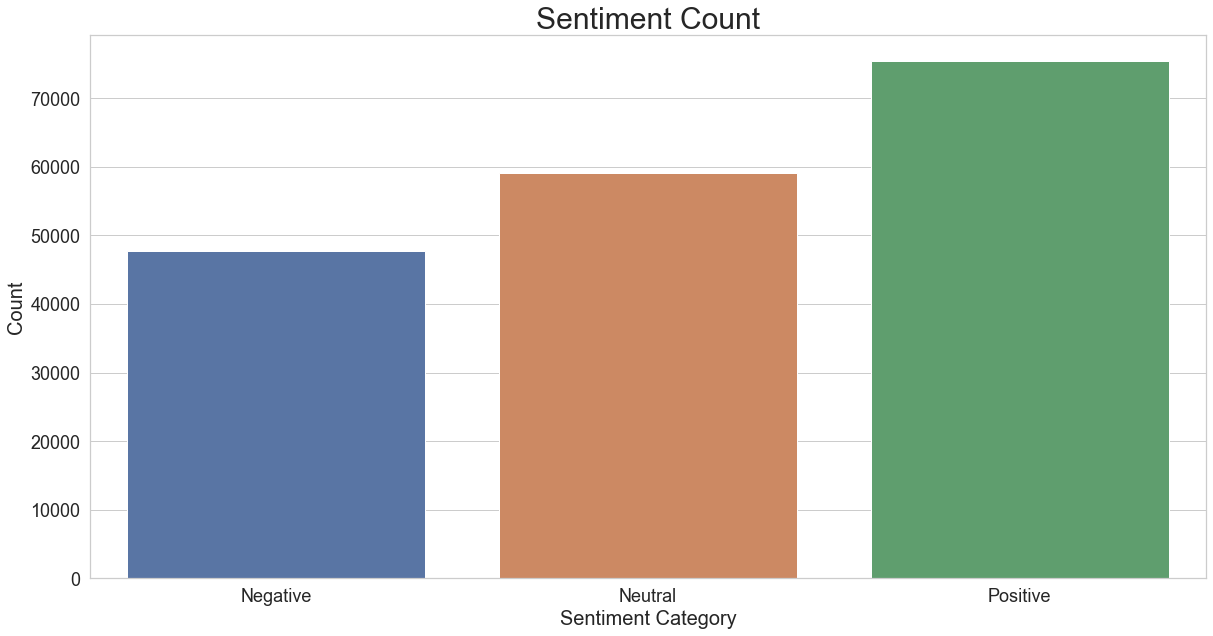

In [21]:
plt.figure(figsize=(20,10))
# set theme
sns.set_theme(style="whitegrid")
#countplot ploarity
sns.countplot(x=cleandf.category)



plt.xlabel('Sentiment Category', fontsize=20)
plt.ylabel('Count', fontsize = 20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Sentiment Count', fontsize=30)

In [27]:
processdf = cleandf
# filter text
processdf['filter_text'] = processdf.clean_text.apply(removeFunc)
processdf.head(1)

In [30]:
#split filtered text
processdf['split_filter_text'] = processdf.filter_text.apply(lambda x: x.split())
processdf.head(1)

,clean_text,score,category,filter_text,split_filter_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised minimum government maximum gover...,"[modi, promised, minimum, government, maximum,..."


In [81]:
# dldf - deep learning data frame
dldf = processdf

# split and filtered data
x_data = dldf.split_filter_text

# numeric score
y_data = dldf.score
print(x_data[3])
print(y_data[3])

['asking', 'supporters', 'prefix', 'chowkidar', 'names', 'modi', 'great', 'service', 'confusion', 'read', 'not', 'crustal', 'clear', 'crass', 'filthy', 'nonsensical', 'see', 'abuses', 'coming', 'chowkidars']
1.0


##### Model 1 - RNN LSTM

In [129]:
# obtain max length for padding
len_mdl1 = get_max_length(x_data)
print(len_mdl1)

15


In [125]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 

# find formula to vectorize the text
token.fit_on_texts(x_data)

#Note: vectorization is assigned to non-Capitalized x_train
# converting text into integer
x_md1 = token.texts_to_sequences(x_data)

### this is the code to add the pad to x_train
x_md1pad = pad_sequences(x_md1, maxlen=len_mdl1, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding
print(x_md1pad[1]) 

[ 214 1079  650  775   11    1    0    0    0    0    0    0    0    0
    0]


In [153]:
y_data=pd.get_dummies(dldf.category)
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_md1pad, y_data, test_size=0.2, random_state=42)

In [154]:
# saving to pickle file
with open('data3/token_mdl1.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading from pickle file
with open('data3/token_mdl1.pickle', 'rb') as handle:
    token = pickle.load(handle)

In [158]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

#### add the model here:
model = Sequential()
model.add(Embedding(total_words,EMBED_DIM,
                  input_length=len_mdl1))
model.add(Dropout(0.1))
# dropout and recurrent dropout
model.add(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(0.1))
model.add(Dense(3, activation='tanh'))

# show a graph of model
tf.keras.utils.plot_model(model, show_shapes=True)

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 15, 32)            3720992   
                                                                 
 dropout_18 (Dropout)        (None, 15, 32)            0         
                                                                 
 lstm_25 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 3)                 195       
                                                                 
Total params: 3,746,019

In [159]:
# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('data3/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [160]:
# fit and train model, call back based on checkpoint(best model)
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/30
2280/2280 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.7108
Epoch 1: accuracy improved from -inf to 0.71077, saving model to data3\LSTM.h5
2280/2280 [==============================] - 103s 44ms/step - loss: 0.4671 - accuracy: 0.7108 - val_loss: 0.3719 - val_accuracy: 0.8205
Epoch 2/30
2280/2280 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8099
Epoch 2: accuracy improved from 0.71077 to 0.80987, saving model to data3\LSTM.h5
2280/2280 [==============================] - 104s 46ms/step - loss: 0.3822 - accuracy: 0.8099 - val_loss: 0.3501 - val_accuracy: 0.8278
Epoch 3/30
2279/2280 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8602
Epoch 3: accuracy improved from 0.80987 to 0.86020, saving model to data3\LSTM.h5
2280/2280 [==============================] - 101s 44ms/step - loss: 0.3109 - accuracy: 0.8602 - val_loss: 0.3219 - val_accuracy: 0.8319
Epoch 4/30
2280/2280 [==============================] -

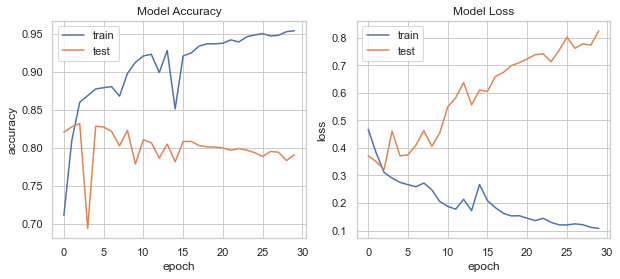

In [162]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'test'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'test'], loc='best')
    
plot_training_hist(history)

##### Model 2 - CNN Bidrectional LSTM (edited on top of KRITANJALI JAIN's model)

In [163]:
max_words = 5000
max_length= 50
# ENCODE REVIEW
token = Tokenizer(num_words=max_words, lower=False)    # False becuase we already did it. 

# find formula to vectorize the text
token.fit_on_texts(x_data)

#Note: vectorization is assigned to non-Capitalized x_train
# converting text into integer
x_token = token.texts_to_sequences(x_data)

### this is the code to add the pad to x_train
x_pad = pad_sequences(x_token, maxlen=max_length, padding='post', truncating='post')

# total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding
print(x_pad[1]) 

[ 214 1079  650  775   11    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [164]:
y = pd.get_dummies(dldf.category)
X_train, X_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (109397, 50) (109397, 3)
Validation Set -> (36466, 50) (36466, 3)
Test Set -> (36466, 50) (36466, 3)


In [165]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [167]:
embedding_size = 32
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()

model.add(Embedding(max_words, embedding_size, input_length=max_length)) # max length did not use 50
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 50, 32)            160000    
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 3)               

In [168]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50
1710/1710 [==============================] - 32s 17ms/step - loss: 0.8543 - accuracy: 0.6058 - precision_8: 0.6895 - recall_8: 0.4527 - val_loss: 0.6707 - val_accuracy: 0.7431 - val_precision_8: 0.7781 - val_recall_8: 0.6867
Epoch 2/50
1710/1710 [==============================] - 27s 16ms/step - loss: 0.5649 - accuracy: 0.7937 - precision_8: 0.8126 - recall_8: 0.7632 - val_loss: 0.4641 - val_accuracy: 0.8472 - val_precision_8: 0.8545 - val_recall_8: 0.8342
Epoch 3/50
1710/1710 [==============================] - 26s 15ms/step - loss: 0.4378 - accuracy: 0.8592 - precision_8: 0.8681 - recall_8: 0.8466 - val_loss: 0.4033 - val_accuracy: 0.8678 - val_precision_8: 0.8744 - val_recall_8: 0.8580
Epoch 4/50
1710/1710 [==============================] - 26s 15ms/step - loss: 0.3971 - accuracy: 0.8749 - precision_8: 0.8828 - recall_8: 0.8651 - val_loss: 0.3885 - val_accuracy: 0.8759 - val_precision_8: 0.8814 - val_recall_8: 0.8692
Epoch 5/50
1710/1710 [==============================] - 

In [171]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8690
Precision : 0.8750
Recall    : 0.8628
F1 Score  : 0.8689


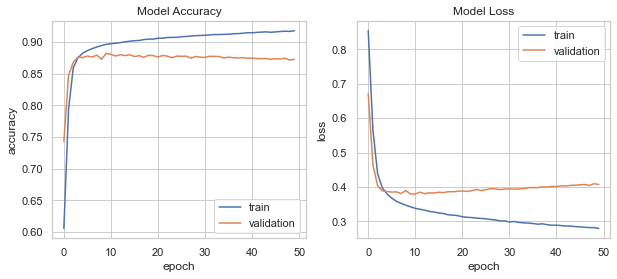

In [172]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

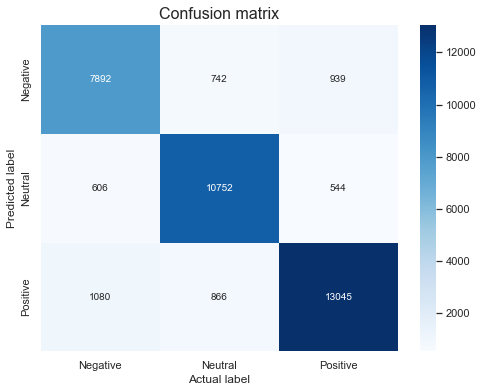

In [173]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [175]:
model.save('data3/bidrectionLSTM.h5')

##### Model 3